In [1]:
import torch.nn as nn
import torch

## Basic Block
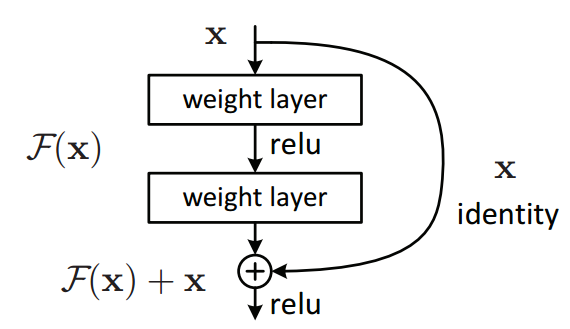

In [3]:
def conv3x3(in_planes, out_planes, stride=1) :
    return nn.Conv2d(in_channels = in_planes,
                     out_channels = out_planes,
                     kernel_size = 3,
                     stride = stride, 
                     padding = 1,
                     bias = False)

class BasicBlock(nn.Module) :
    expansion = 1
    
    def __init__(self, in_planes, planes, stride=1, downsample = None) :
        super(BasicBloc, self).__init__()
        self.conv1 = conv3x3(in_planes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace = True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride
        
    def forward(self, x) :
        residual = x
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        
        if self.downsample is not None : 
            residual = self.downsample(x)
            
        out += residual
        out = self.relu(out)
        
        return out

## BottleNeck Layer
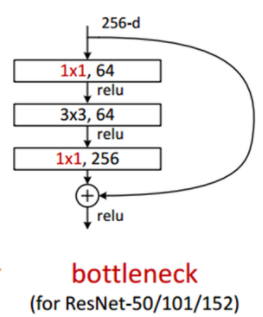

In [4]:
class BottleNeck(nn.Module) :
    expansion = 4
    
    def __init__(self, inplanes, planes, stride = 1, downsample = None) :
        super(BottleNeck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes,
                               planes,
                               kernel_size = 3,
                               stride = stride,
                               padding =1, 
                               bias = False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes*expansion, kernel_size = 1, bias = False)
        self.bn3 = nn.BatchNorm2d(planes * expansion)
        self.relu = nn.ReLU(inplace = True)
        self.downsample = downsample
        self.stride = stride
        
    def forward(self, x) :
        residual = x
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.conv2(out)
        out = self.bn2(out)
        
        out = self.conv3(out)
        out = self.bn3(out)
        
        if self.downsample is not None :
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        
        return out

In [5]:
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=1000):
        super(ResNet, self).__init__()
        self.inplanes = 128
        self.conv1 = conv3x3(3, 64, stride=2)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(64, 64)
        self.bn2 = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU(inplace=True)
        self.conv3 = conv3x3(64, 128)
        self.bn3 = nn.BatchNorm2d(128)
        self.relu3 = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        # self.avgpool = nn.AvgPool2d(7, stride=1)
        # self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes,
                          planes * block.expansion,
                          kernel_size=1,
                          stride=stride,
                          bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.relu1(self.bn1(self.conv1(x)))
        x = self.relu2(self.bn2(self.conv2(x)))
        x = self.relu3(self.bn3(self.conv3(x)))
        x = self.maxpool(x)

        f = []
        x = self.layer1(x)
        f.append(x)
        x = self.layer2(x)
        f.append(x)
        x = self.layer3(x)
        f.append(x)
        x = self.layer4(x)
        f.append(x)

        return tuple(f)